GalCat: included galaxies: 84916 of 7571324
GalCat: included galaxies: 204656 of 40895931
ndmap([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21601.00,7561.00]}) ndmap([[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]],car:{cdelt:[-0.008333,0.008333],crval:[0,0],crpix:[21601.00,7561.00]})


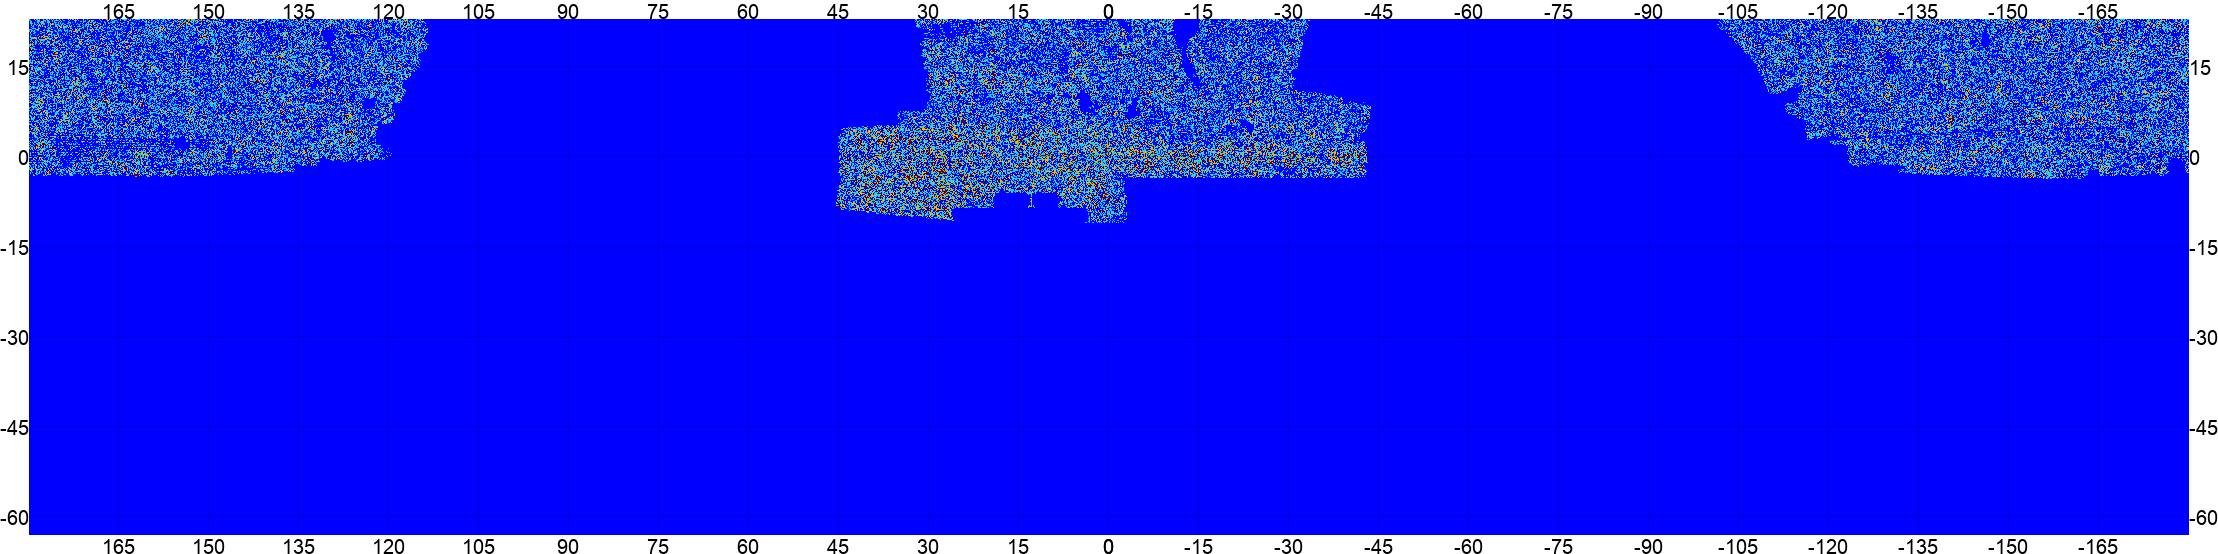

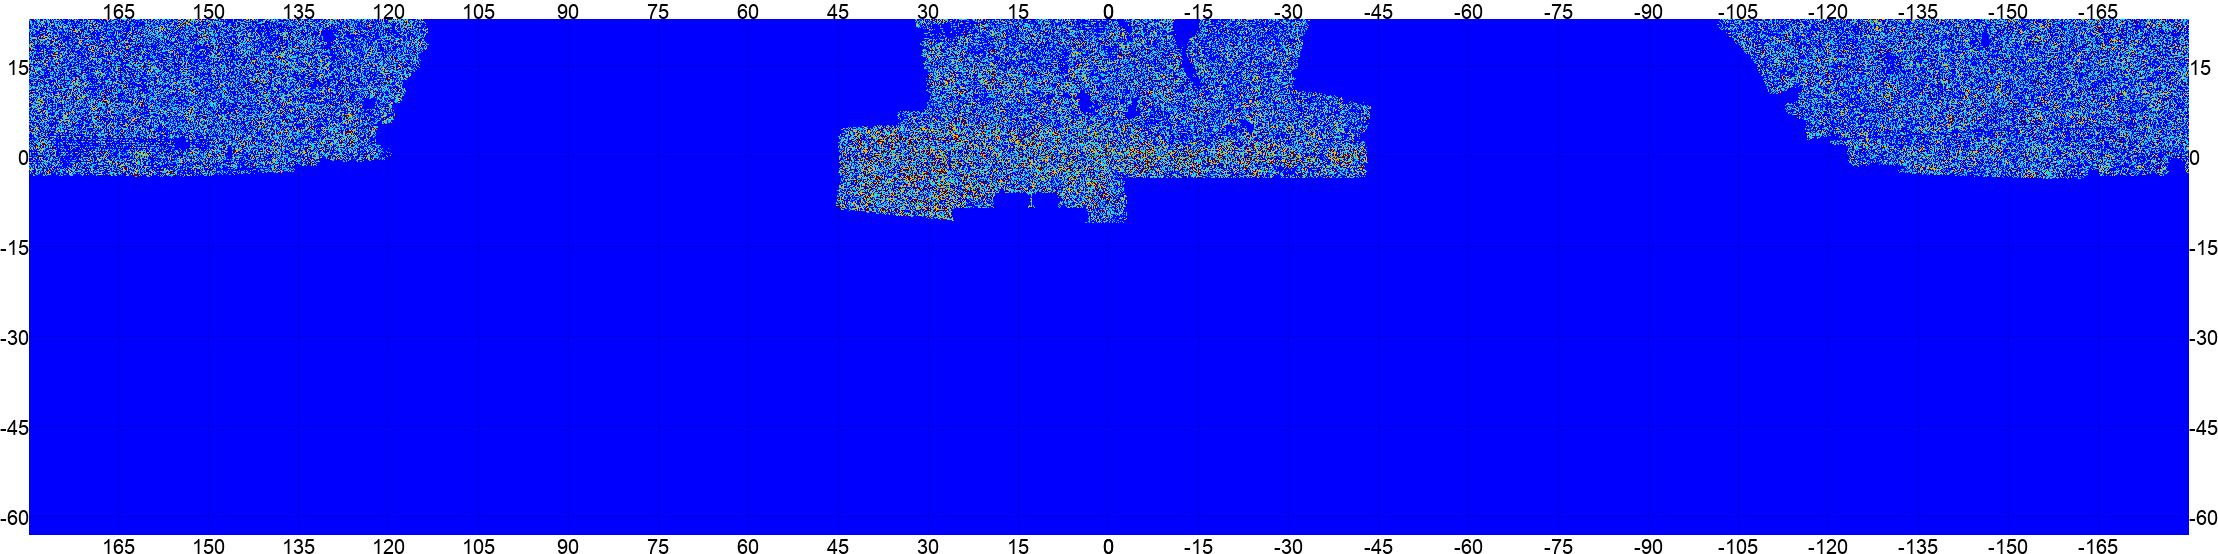

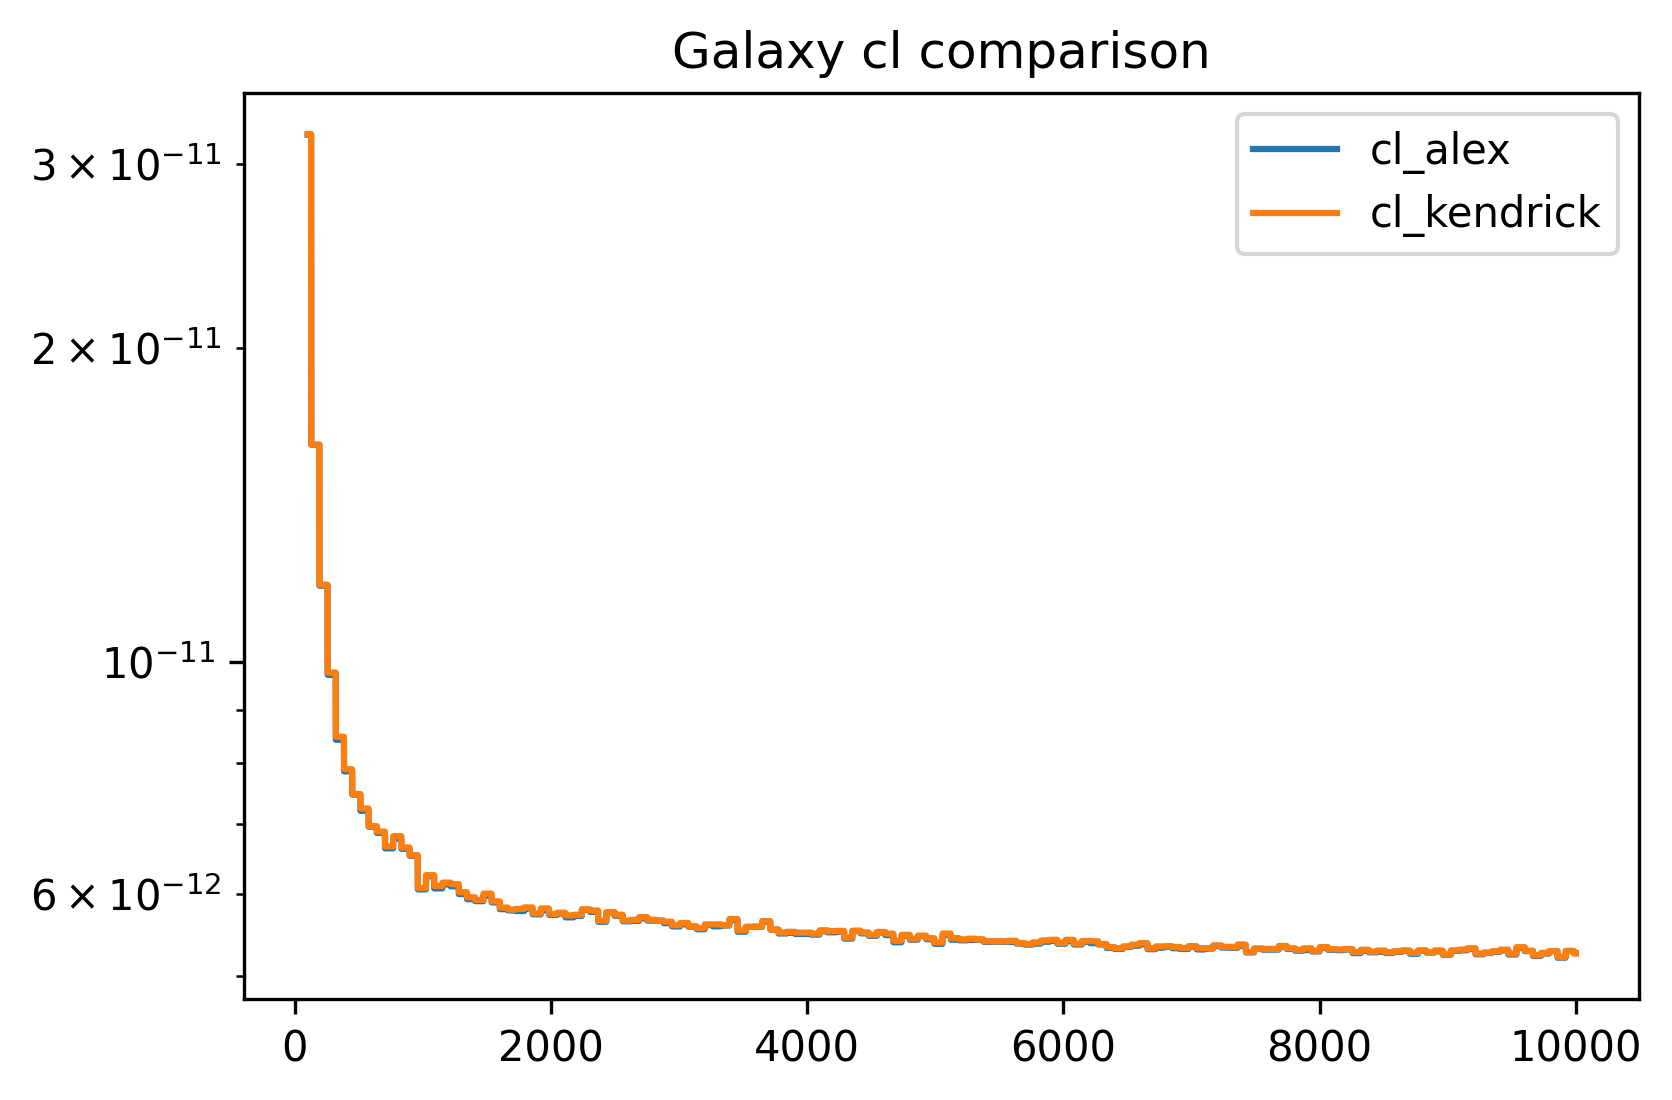

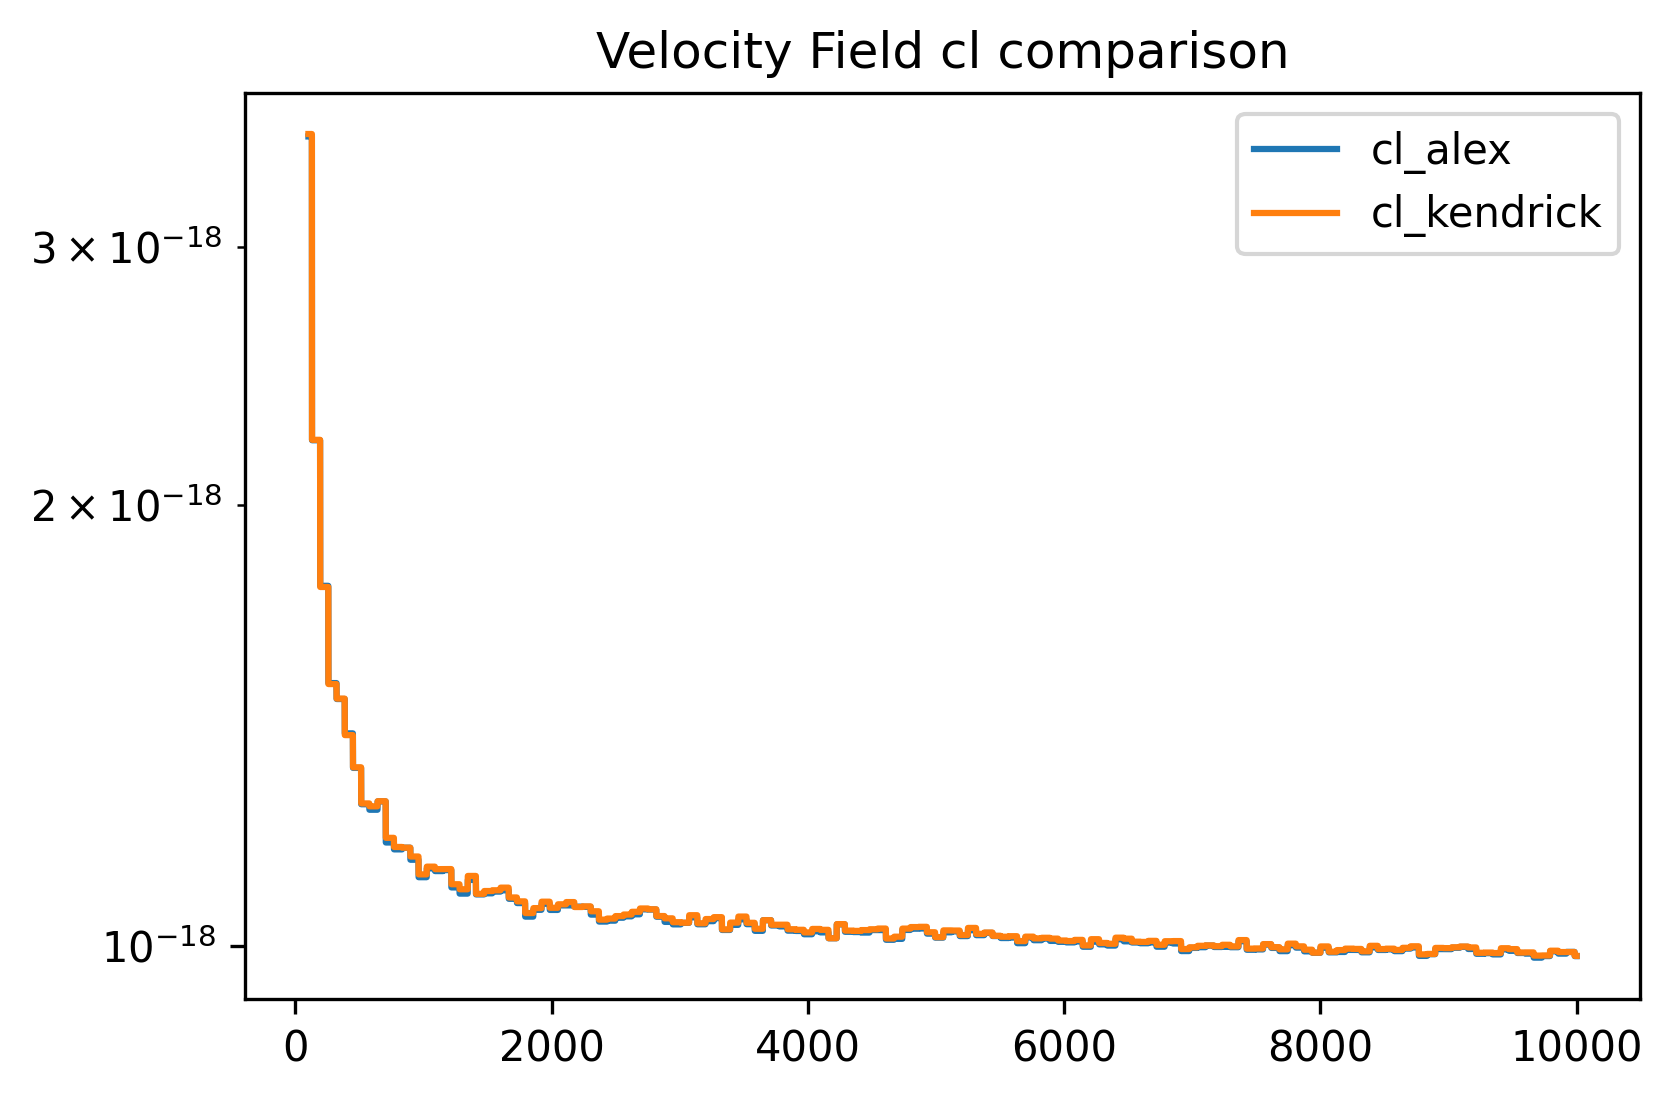

0.3127705133793899


In [1]:
from pixell import enmap, enplot
from pixell.curvedsky import map2alm, alm2cl

import numpy as np
import matplotlib.pyplot as plt

from fnl_pipe.util import map2cl, average_fl
from fnl_pipe.galaxy import DESILSCat, AndCut, NullCut, LRGNorthCut, LRGSouthCut, ZerrCut

# def map2cl(map_t, lmax):
#     return alm2cl(map2alm(map_t, lmax=lmax))

lmax=10000
nave_fl = 64
freq_str='150'

data_path = '/home/aroman/data/'
act_path = data_path + 'act_pub/'
desils_v3_north = data_path + 'vr_source/desils/v03_desils_north_cmass.h5'
desils_v3_south = data_path + 'vr_source/desils/v03_desils_south_cmass.h5'
desils_cat = DESILSCat(cat_north=desils_v3_north, cat_south=desils_v3_south)

map_path = act_path + f'act_planck_dr5.01_s08s18_AA_f{freq_str}_daynight_map_srcfree.fits' # public

# north_cut = NullCut()
# south_cut = NullCut()
zerr_cut = ZerrCut(0.0225)
north_cut = AndCut([LRGNorthCut(), zerr_cut])
south_cut = AndCut([LRGSouthCut(), zerr_cut])

ref_map = enmap.read_map(map_path)[0]

gal_pipe = desils_cat.get_subcat([north_cut, south_cut], ref_map, '1.0')
gal_pipe.import_data()
gal_pipe.make_vr_list()

alex_gal_map = gal_pipe.get_gal_map()
alex_vel_map = gal_pipe.get_vr_map()

kdata_base = '/home/aroman/data/kendrick/'
kgal_map_path = kdata_base + '02_pixellized_lss_maps/pixellized_galaxy_map.fits'
kgal_vel_map_path = kdata_base + '02_pixellized_lss_maps/pixellized_velocity_weighted_galaxy_map.fits'

kgal_map = enmap.read_map(kgal_map_path)
kgal_vel_map = enmap.read_map(kgal_vel_map_path)

assert kgal_map.shape == ref_map.shape
print(kgal_map, ref_map)

# TODO: add area-weighted galaxy map in GalCat

figs = []
figs.append(enplot.plot(kgal_map, downgrade=20, ticks=15))
figs.append(enplot.plot(alex_gal_map, downgrade=20, ticks=15))
for fig in figs: enplot.show(fig)
    
def get_area_weight(map_t):
    cdelt = map_t.wcs.wcs.cdelt * np.pi / 180. # dec, ra
    dOmega = cdelt[0] * cdelt[1]
    pos = map_t.posmap() # map_centers
    decs, ras = pos
    weights = np.abs(dOmega * np.sin(pos[0]))
    return weights

def do_cl_compare(cl_alex, cl_kendrick, title, normalize_tail=True, lmin=100):
    
    ells = np.arange(len(cl_alex))[lmin + 1:]
    norm = ells * (ells + 1) / 2 / np.pi
    plt.figure(dpi=300, facecolor='w')
    plt.title(title)
    knorm = 1.
    if normalize_tail:
        knorm = cl_alex[-50:].sum() / cl_kendrick[-50:].sum()
    plt.plot(ells, cl_alex[lmin + 1:], label='cl_alex')
    plt.plot(ells, knorm * cl_kendrick[lmin + 1:], label='cl_kendrick')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
weights = get_area_weight(kgal_map)
# alex_gal_map *= weights
# alex_vel_map *= weights
# alex_gal_map *= kgal_map.sum() / alex_gal_map.sum()
# alex_vel_map *= np.abs(kgal_vel_map).sum() / np.abs(alex_vel_map).sum()

cl_gal_alex = average_fl(map2cl(alex_gal_map, lmax=lmax), nave_fl)
cl_vel_alex = average_fl(map2cl(alex_vel_map, lmax=lmax), nave_fl)
cl_gal_kendrick = average_fl(map2cl(kgal_map, lmax=lmax), nave_fl)
cl_vel_kendrick = average_fl(map2cl(kgal_vel_map, lmax=lmax), nave_fl)
do_cl_compare(cl_gal_alex, cl_gal_kendrick, 'Galaxy cl comparison')
do_cl_compare(cl_vel_alex, cl_vel_kendrick, 'Velocity Field cl comparison')
area = weights.sum() / 4 / np.pi
print(area)


In [9]:
import h5py

kgal_cat_path = kdata_base + '02_pixellized_lss_maps/galaxy_catalog.h5'
with h5py.File(kgal_cat_path, 'r') as file:
    print(file.keys())
    print(file['dec_deg'])
    print(file['Gmag'])
    


<KeysViewHDF5 ['Gmag', 'W1mag', 'W2mag', 'dec_deg', 'fracflux_g', 'fracflux_r', 'fracflux_z', 'fracin_g', 'fracin_r', 'fracin_z', 'fracmasked_g', 'fracmasked_r', 'fracmasked_z', 'gmag', 'maskbits', 'morphology', 'nobs_g', 'nobs_r', 'nobs_z', 'ra_deg', 'rfibermag', 'rmag', 'vr', 'z', 'zerr', 'zfibermag', 'zmag']>
<HDF5 dataset "dec_deg": shape (204728,), type "<f8">
<HDF5 dataset "Gmag": shape (204728,), type "<f4">
